# Testing out how to process dendritic events as a binary series.

In [4]:
import os
import sys
sys.path.append('..') # have to do this for relative imports in jupyter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.cc_serpt import cc_serpt
from src.ser_ss import ser_ss
from src.load_dendevt_csv import load_dendevt_csv
from src.load_spike_h5 import load_spike_h5
from src.permute_pt import permute_pt
from src.seg_dendevt import seg_dendevt
from src.ser_seg_dendevt import ser_seg_dendevt

In [2]:
# files to pull data from
spk_fname = 'Y:\\DendCompOsc\\16Hzapical_exc_mod\\output_16Hz_dend_inh_0deg_exc_10p\spikes.h5'
ca_fname = 'Y:\\DendCompOsc\\16Hzapical_exc_mod\\output_16Hz_dend_inh_0deg_exc_10p_ca.csv'
na_fname = 'Y:\\DendCompOsc\\16Hzapical_exc_mod\\output_16Hz_dend_inh_0deg_exc_10p_na.csv'
nmda_fname = 'Y:\\DendCompOsc\\16Hzapical_exc_mod\\output_16Hz_dend_inh_0deg_exc_10p_nmda.csv'

In [3]:
# load data
spk_t = load_spike_h5(spk_fname)
ca_t = load_dendevt_csv(ca_fname)
na_t = load_dendevt_csv(na_fname)
nmda_t = load_dendevt_csv(nmda_fname)

C:\Users\dbh60\AppData\Local\Temp/ipykernel_5424/3804444408.py:3: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  ca_t = load_dendevt_csv(ca_fname)
C:\Users\dbh60\AppData\Local\Temp/ipykernel_5424/3804444408.py:4: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  na_t = load_dendevt_csv(na_fname)
C:\Users\dbh60\AppData\Local\Temp/ipykernel_5424/3804444408.py:5: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  nmda_t = load_dendevt_csv(nmda_fname)


In [5]:

# figure out window
print(np.max(nmda_t['nmda_lower_bound']))
samps_per_ms = 10
sim_win = [0, 2000000]
step = 2 * samps_per_ms

1989593.0


In [6]:
# group times within segments
ca_seg = seg_dendevt(ca_t)

# create trace of calcium spike periods
ca_seg = ser_seg_dendevt(ca_seg)
ca_ser_temp = []
for _,x in ca_seg.iterrows():
    ca_ser_temp.append(np.array(ser_ss(x['ca_lower_bound'],x['ca_upper_bound'],step,sim_win)))
ca_seg['ca_ser'] = ca_ser_temp

In [7]:
# get spike triggered average for each ca events
sta_temp = []
spks = spk_t #permute_pt(spk_t)
for _,x in ca_seg.iterrows():
    sta_temp.append(cc_serpt(x['ca_ser'],spks.astype(int)/step,1,[-100,100])['values'])

# percent change
prc_func = lambda x: ((x-np.mean(x))/np.mean(x))*100
ca_seg['ca_sta'] = sta_temp
ca_seg['ca_sta_prc'] = ca_seg['ca_sta'].apply(prc_func)

# merge segments by electronic distance quantile
agg_func = {'ca_sta_prc':lambda x: np.mean(np.vstack(x),0)}
ca_seg = ca_seg.groupby('Elec_distanceQ').aggregate(agg_func)

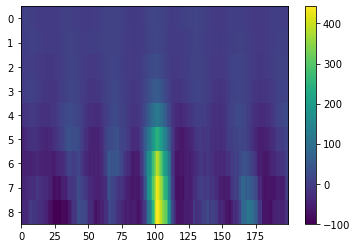

In [8]:
sta_arr = np.vstack(ca_seg['ca_sta_prc'])
fig, ax = plt.subplots()
plt.imshow(sta_arr, interpolation='none')
plt.colorbar()
ax.set_aspect('auto')
plt.show()


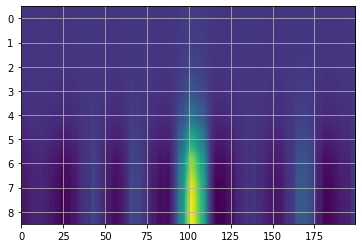

In [52]:
u,s,v = np.linalg.svd(sta_arr)
fig, ax = plt.subplots()
ax.imshow(np.matmul(u[:,0:1]*s[0:1],v[0:1,:]))
ax.grid(which='both')
ax.set_aspect('auto')
plt.show()

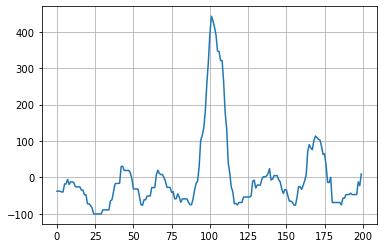

In [57]:
fig, ax = plt.subplots()
ax.plot(sta_arr[8,:])
ax.grid(which='both')
plt.show()

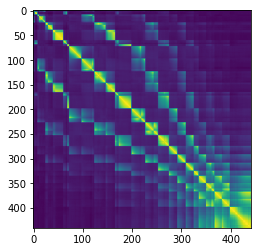

In [27]:
test = np.corrcoef(ca_arr)
fig, ax = plt.subplots()
ax.imshow(test)
plt.show()